In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
sns.set()
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Function Definitions

• ***processDataFrame(file_name):*** takes a file name, loads data in CSV format, and outputs a data frame

• ***dataCleaning(df):*** takes a data frame, encodes categorical variables, imputes missing values, and outputs the updated data frame

• ***countplotConstructor(df):*** takes a data frame and constructs countplots for the categorical variables

• ***histogramConstructor(df):*** takes a data frame, constructs histograms for the quantitative variables, and fits a kernel density estimate to the histogram

• ***scatterplotConstructor(df, a, c):*** takes a data frame, transparency parameter, and a color parameter; it creates six scatter plots, one per predictor variable

• ***printMetrics(y_test, predictions):*** takes the actual and the predicted diamond prices and calculates some relevant performance metrics

• ***residualPlotConstructor(y_test, predictions, a, c1, c2):*** takes the actual and predicted diamond prices, a transparency parameter, and two color parameters; it constructs a residual plot

In [ ]:
def processDataFrame(file_name):
    df = pd.read_csv(file_name)
    print(df.info())
    print(df.describe())
    
    return df
    
def dataCleaning(df):
    cut_map = {'Fair':1, 'Good':2, 'Very Good':3, 'Premium':4, 'Ideal':5}
    color_map = {'D':7, 'E':6, 'F':5, 'G':4, 'H':3, 'I':2, 'J':1}
    clarity_map = {'I1':1, 'SI1':2, 'SI2':3, 'VS1':4, 'VS2':5, 'VVS1':6, 'VVS2':7, 'IF':8}
        
    df.cut = df.cut.replace(cut_map)
    df.color = df.color.replace(color_map)
    df.clarity = df.clarity.replace(clarity_map)
    
    df.x[df.x == 0.0] = df.x.mean()
    df.y[df.y == 0.0] = df.y.mean()
    df.z[df.z == 0.0] = df.z.mean()
    
    df.dropna()
    df.reset_index(drop = True)
    
    return df

def countplotConstructor(df):
    fig, axes = plt.subplots(nrows = 3, figsize = (15, 15))
    sns.countplot(x = 'cut', data = df, ax = axes[0], order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'])
    sns.countplot(x = 'color', data = df, ax = axes[1], order = ['J', 'I', 'H', 'G', 'F', 'E', 'D'])
    sns.countplot(x = 'clarity', data = df, ax = axes[2], order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'])
    
    plt.tight_layout()
    
def histogramConstructor(df):
    columns = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
    fig, axes = plt.subplots(nrows = len(columns), figsize = (18, 18))
    for i in range(len(columns)):
        sns.distplot(df[columns[i]], kde = True, ax = axes[i])
        axes[i].set(xlabel = columns[i], ylabel = 'frequency', title = columns[i])
    
    plt.tight_layout()    

def boxplotConstructor(df):
    columns = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
    fig, axes = plt.subplots(nrows = len(columns), figsize = (18, 18))
    for i in range(len(columns)):
        sns.boxplot(df[columns[i]], ax = axes[i])
    
    plt.tight_layout()    

def scatterplotConstructor(df, ylabel, a, c):
    fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 18))
    axes[0, 0].scatter(df.carat, df.price, alpha = a, color = c)
    axes[0, 1].scatter(df.depth, df.price, alpha = a, color = c)
    axes[0, 2].scatter(df.table, df.price, alpha = a, color = c)
    axes[1, 0].scatter(df.x, df.price, alpha = a, color = c)
    axes[1, 1].scatter(df.y, df.price, alpha = a, color = c)
    axes[1, 2].scatter(df.z, df.price, alpha = a, color = c)

    axes[0, 0].set(xlabel = 'carat', ylabel = ylabel, title = 'price vs carat')
    axes[0, 1].set(xlabel = 'depth', ylabel = ylabel, title = 'price vs depth')
    axes[0, 2].set(xlabel = 'table', ylabel = ylabel, title = 'price vs table')
    axes[1, 0].set(xlabel = 'x-dimension', ylabel = ylabel, title = 'price vs x-dimension')
    axes[1, 1].set(xlabel = 'y-dimension', ylabel = ylabel, title = 'price vs y-dimension')
    axes[1, 2].set(xlabel = 'z-dimension', ylabel = ylabel, title = 'price vs z-dimension')

    plt.tight_layout()

def printMetrics(y_test, predictions):
    mae = metrics.mean_absolute_error(y_test, predictions)
    mse = metrics.mean_squared_error(y_test, predictions)
    mape = np.mean(np.abs(y_test - predictions) / np.abs(y_test))
    
    print('Mean Absolute Error: ', mae)
    print('Mean Squared Error: ', mse)
    print('Root Mean Squared Error: ', np.sqrt(mse))
    print('Mean Absolute Percentage Error: ', round(mape * 100, 2), '%')
    print('Accuracy: ', round(100 * (1 - mape), 2), '%')
    
def residualPlotConstructor(y_test, predictions, a, c1, c2):
    fig, ax = plt.subplots()
    ax.set(xlabel = 'Predicted Price', ylabel = 'Actual Price - Predicted Price', title = 'Residual Plot')
    ax.scatter(predictions, y_test - predictions, alpha = a, color = c1)
    ax.axhline(y = 0, color = c2)

#The Data

##Data Exploration
The data frame has a 53940x10 shape. There are no obvious missing values. However, a brief inspection of the statistical summary shows that there are some hidden missing values. The minimum values for the variables ***x, y, z*** are ***0.0***. Since the three variables represent physical dimensions, a measure of ***0.0*** does not make sense. The ***0.0*** is likely a placeholder for missing values. Compared to the overall size of the data set, the number of missing values is negligible; however, I still imputed the missing values by replacing the ***0.0***'s in each column with the average of the corresponding variable.

In [ ]:
file_name = '/content/diamonds.csv'
df = processDataFrame(file_name)
df[df == 0.0].count(axis = 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB
None
         Unnamed: 0         carat  ...             y             z
count  53940.000000  53940.000000  ...  53940.000000  53940.000000
mean   26970.500000      0.797940  ...      5.734526      3.538734
std    15571.281097      0.474011  ...      1.142135      0.705699
min        1.000000    

Unnamed: 0     0
carat          0
cut            0
color          0
clarity        0
depth          0
table          0
price          0
x              8
y              7
z             20
dtype: int64

The majority of the variables — except for ***depth*** — are highly correlated with ***price***.

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']


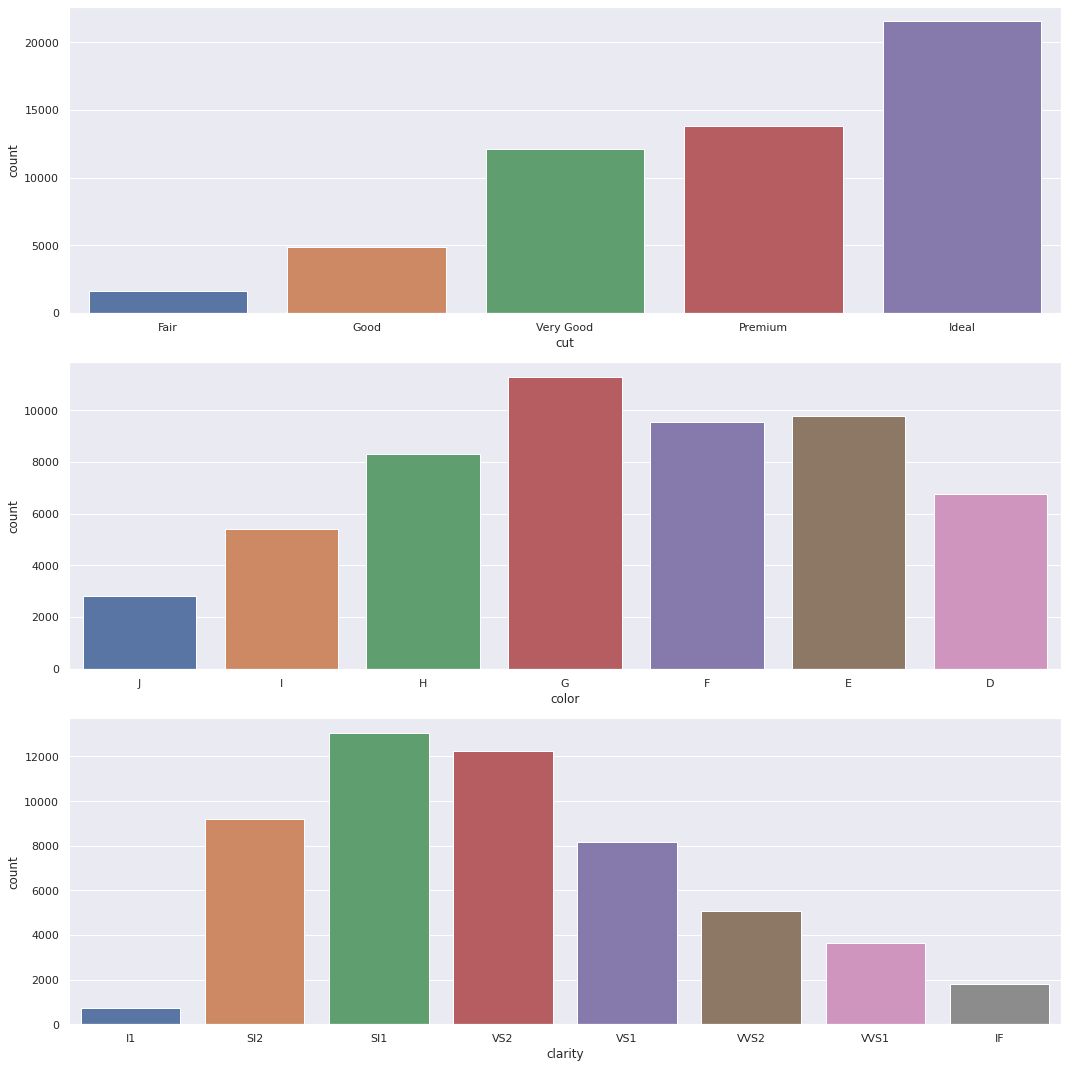

In [ ]:
print(df.cut.unique())
print(df.color.unique())
print(df.clarity.unique())
countplotConstructor(df)

In [ ]:
df.corr()

,Unnamed: 0,carat,depth,table,price,x,y,z
Unnamed: 0,1.000000,-0.377983,-0.034800,-0.100830,-0.306873,-0.405440,-0.395843,-0.399208
carat,-0.377983,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,-0.034800,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,-0.100830,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,-0.306873,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,-0.405440,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,-0.395843,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,-0.399208,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


I retained all predictors except for ***Unnamed: 0*** (the index column) and ***depth***.

In [ ]:
df = dataCleaning(df)
y = df.price
X = df.drop(columns = ['Unnamed: 0', 'depth', 'price'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The variables ***carat, price, and x*** are skewed to the right. The distributions of the variables ***table, y, and z*** are jagged. The variable ***depth*** is fairly symmetric, but even that distribution has long tails on each side, suggesting potential extreme values.

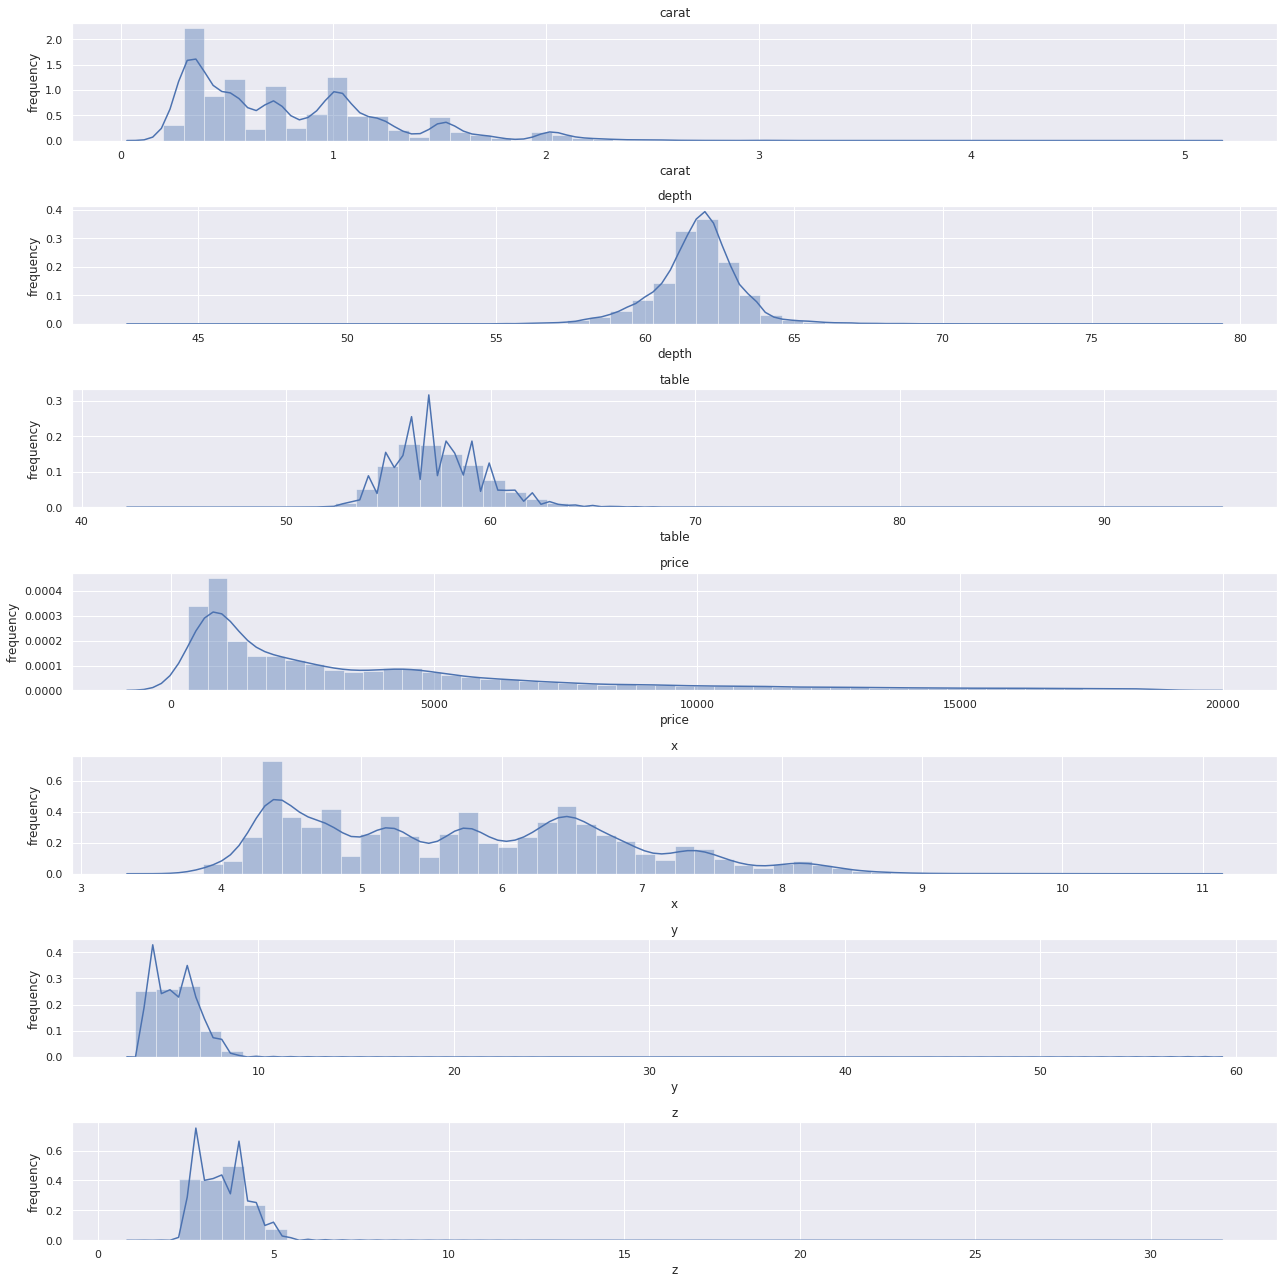

In [ ]:
histogramConstructor(df)

The boxplots make more explicit what the histograms and kde's suggest. Each variable has a considerable number of outliers, either on one or both ends of the distribution. There is nothing about the data to suggest that the outliers are typos or incorrect in some other way. Removing them might lead to a better model fit, but doing so would also remove some of the nuance and variation of the data. Regular multivariate regression and other techniques can be sensitive to extreme values. To avoid this problem, I retained the outliers but used a random forest regressor, which is more robust to outliers.

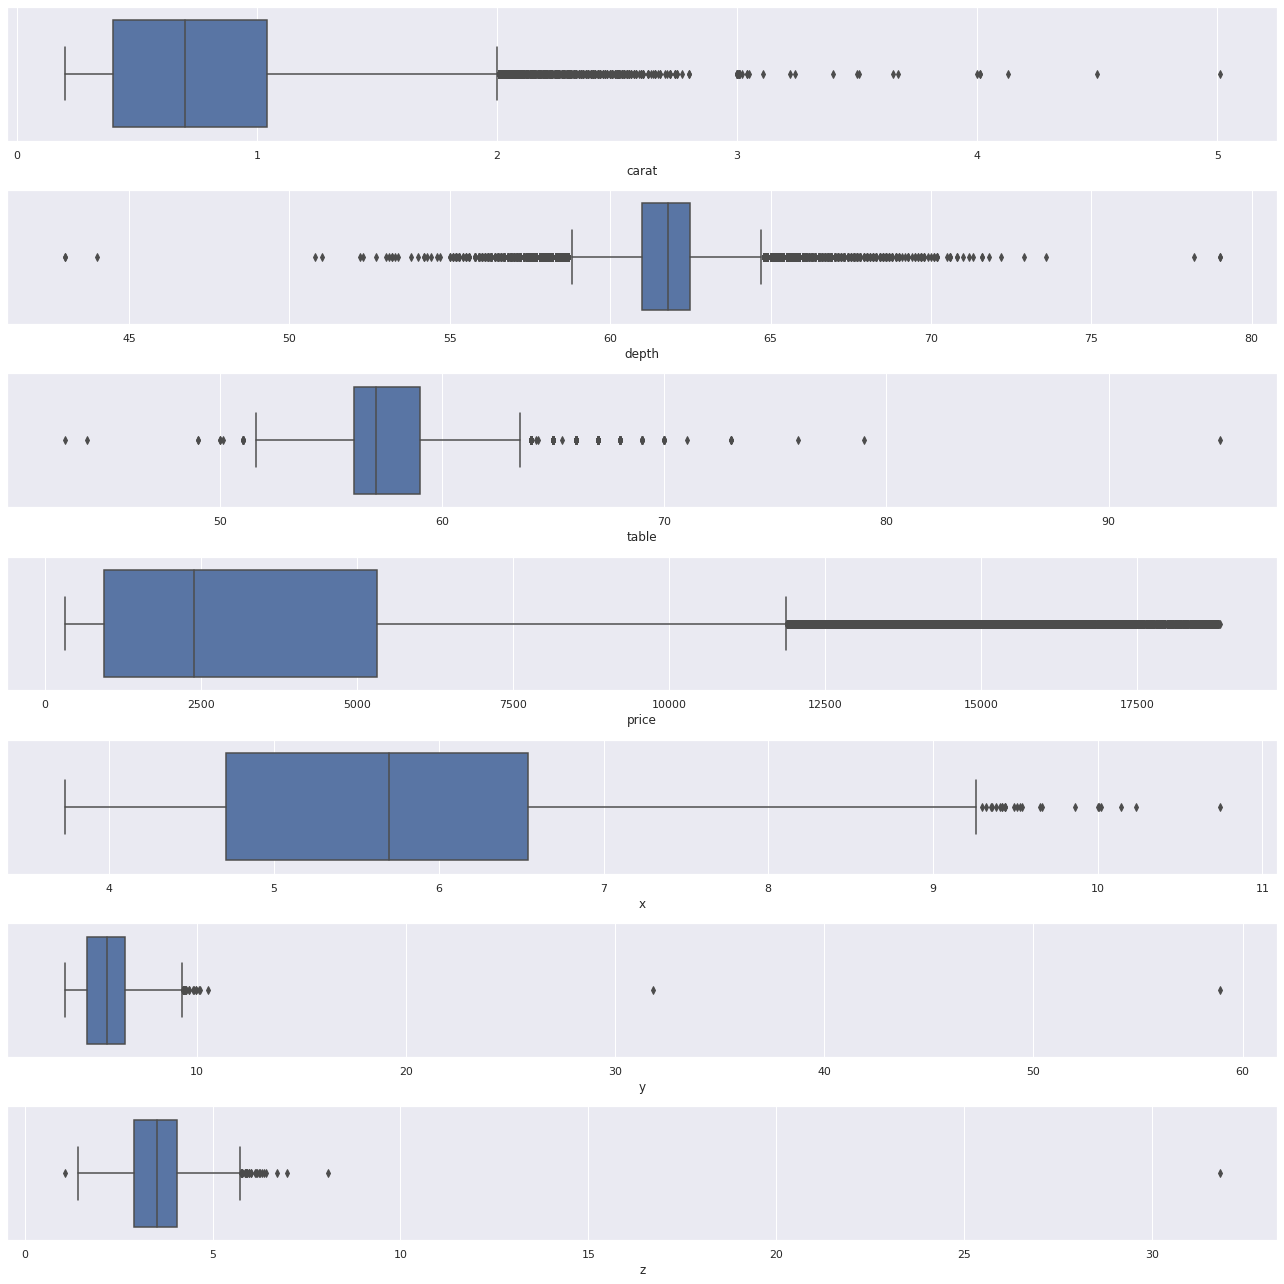

In [ ]:
boxplotConstructor(df)

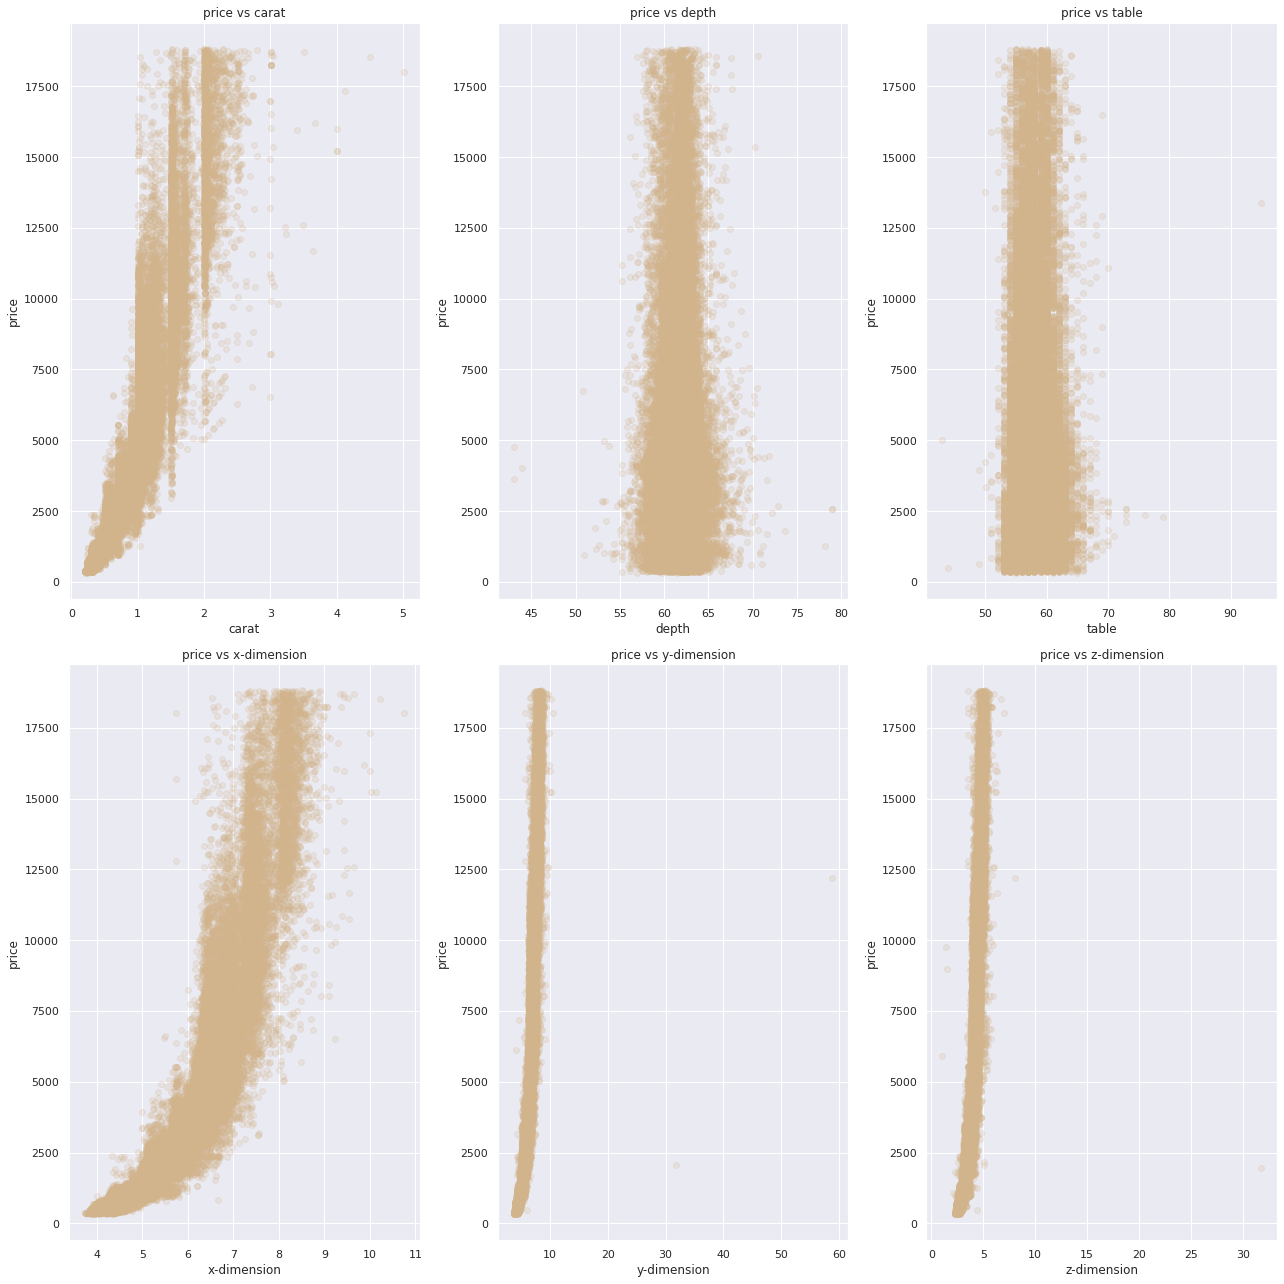

In [ ]:
scatterplotConstructor(df, 'price', a = 0.2, c = 'tan')

#The Model:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)

##Performance Metrics & Residual Plot

Mean Absolute Error:  269.78957674105857
Mean Squared Error:  292985.711185578
Root Mean Squared Error:  541.281545210603
Mean Absolute Percentage Error:  6.47 %
Accuracy:  93.53 %


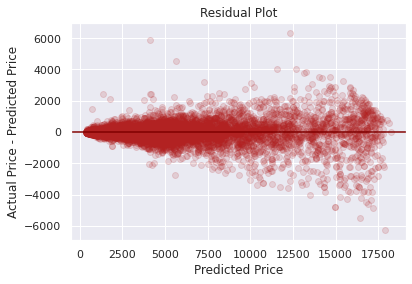

In [ ]:
printMetrics(y_test, predictions)
residualPlotConstructor(y_test, predictions, 0.15, 'firebrick', 'maroon')

For low predicted prices, the residuals are closely centered around y = 0. As predicted price increases, the residuals start diverging from y = 0, but still mostly concentrate around the horizontal line.

Dataset used: https://www.kaggle.com/shivam2503/diamonds